In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2

from flygym.util.hybrid_turning_controller import NMFHybridTurning
from flygym.util.cpg_controller import plot_phase_amp_output_rules, sine_output

In [2]:
# Initialize the simulation
enable_adhesion = True
run_time = 2.5
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_bottom",
    render_playspeed=0.1,
    actuator_kp=30,
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
)
nmf = NMFHybridTurning(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos = [0, 0, 0.2],
    stabilisation_dur = 1.0
)

num_steps_base = int(run_time / nmf.timestep)

In [3]:
# Set variables
num_steps = num_steps_base
seed = 42

def generate_turning(turn_action, turn_dur=0.5, turn_min_init=0.5, turn_indicator_radius=25):
    
    np.random.seed(seed)
    
    # always initiate the turn at a moment that is equivalent for both side (lets say when the inner leg is at indice 0 and when time is above tun_min_init)
    turn_start = np.inf
    turn_end = np.inf

    inner_leg = 0 if turn_action[0] > turn_action[1] else 3 if turn_action[0] < turn_action[1] else 0

    obs, info = nmf.reset()
    phases, amplitudes, obs_list = nmf.run_stabilisation()
    stumble_active = [False]*len(phases)
    retract_active = [False]*len(phases)
    action = [0,0]
    for i in trange(num_steps):

        internal_leg_rounded_cpg_phase = np.round(nmf.cpg.phase[inner_leg], 1) #phase is already clipped between 0 and 2pi
        if not np.isfinite(turn_end) and internal_leg_rounded_cpg_phase <= 0.0 and i > turn_min_init/nmf.timestep:
            turn_start = i
            turn_end = i + turn_dur/nmf.timestep
            action = turn_action
            print("Start turning")
        if i == turn_end:
            print(action)
            action = [0,0]
            print("Stop turning")

        obs, reward, terminated, truncated, info = nmf.step(action)
        obs_list.append(obs)
        
        # For now lets comment the hybrid stuff and focus on turning
        stumble_active.append(nmf.stumble_active)
        retract_active.append(nmf.leg_retract_active)
        
        render_status = nmf.render()
        if render_status and i > turn_start and i < turn_end:
            last_frame = nmf.get_last_frame()
            cv2.circle(last_frame,(turn_indicator_radius,turn_indicator_radius), turn_indicator_radius, (0, 0, 255), -1)

        phases.append(nmf.cpg.phase)
        amplitudes.append(nmf.cpg.amplitude)
    
    return obs_list, turn_start+nmf.n_stabilisation_steps, turn_end+nmf.n_stabilisation_steps, phases, amplitudes, stumble_active, retract_active, nmf

 21%|██        | 5211/25000 [00:13<00:59, 335.25it/s]

Start turning


 41%|████      | 10195/25000 [00:27<00:43, 338.65it/s]

[1.0, -1.0]
Stop turning


 21%|██        | 5212/25000 [00:14<00:55, 354.89it/s]

Start turning


 41%|████      | 10175/25000 [00:29<00:55, 265.76it/s]

[0.0, -1.0]
Stop turning


 21%|██        | 5192/25000 [00:14<00:58, 340.81it/s]

Start turning


 41%|████      | 10194/25000 [00:29<00:50, 294.26it/s]

[0.0, -0.5]
Stop turning


 21%|██        | 5232/25000 [00:14<00:53, 371.98it/s]

Start turning


 41%|████      | 10212/25000 [00:28<00:46, 318.88it/s]

[0.1, -0.4]
Stop turning


 21%|██        | 5208/25000 [00:14<00:57, 345.30it/s]

Start turning


 41%|████      | 10214/25000 [00:28<00:42, 345.82it/s]

[0.0, -0.2]
Stop turning


 21%|██        | 5199/25000 [00:13<00:57, 341.94it/s]

Start turning


 41%|████      | 10221/25000 [00:27<00:42, 344.46it/s]

[0.0, 0.0]
Stop turning


 23%|██▎       | 5636/25000 [00:15<00:51, 374.85it/s]

Start turning


 42%|████▏     | 10595/25000 [00:30<00:48, 294.92it/s]

[-0.2, 0.0]
Stop turning


 22%|██▏       | 5602/25000 [00:15<00:53, 365.72it/s]

Start turning


 43%|████▎     | 10637/25000 [00:29<00:39, 364.40it/s]

[-0.5, 0.0]
Stop turning


 22%|██▏       | 5614/25000 [00:15<00:53, 362.04it/s]

Start turning


 43%|████▎     | 10631/25000 [00:29<00:40, 353.18it/s]

[-0.4, 0.1]
Stop turning


 22%|██▏       | 5619/25000 [00:15<00:52, 367.09it/s]

Start turning


 42%|████▏     | 10621/25000 [00:30<00:48, 295.38it/s]

[-1.0, 0.0]
Stop turning


 22%|██▏       | 5601/25000 [00:15<00:54, 355.37it/s]

Start turning


 42%|████▏     | 10619/25000 [00:29<00:42, 336.14it/s]

[-1.0, 1.0]
Stop turning


100%|██████████| 25000/25000 [01:08<00:00, 365.74it/s]


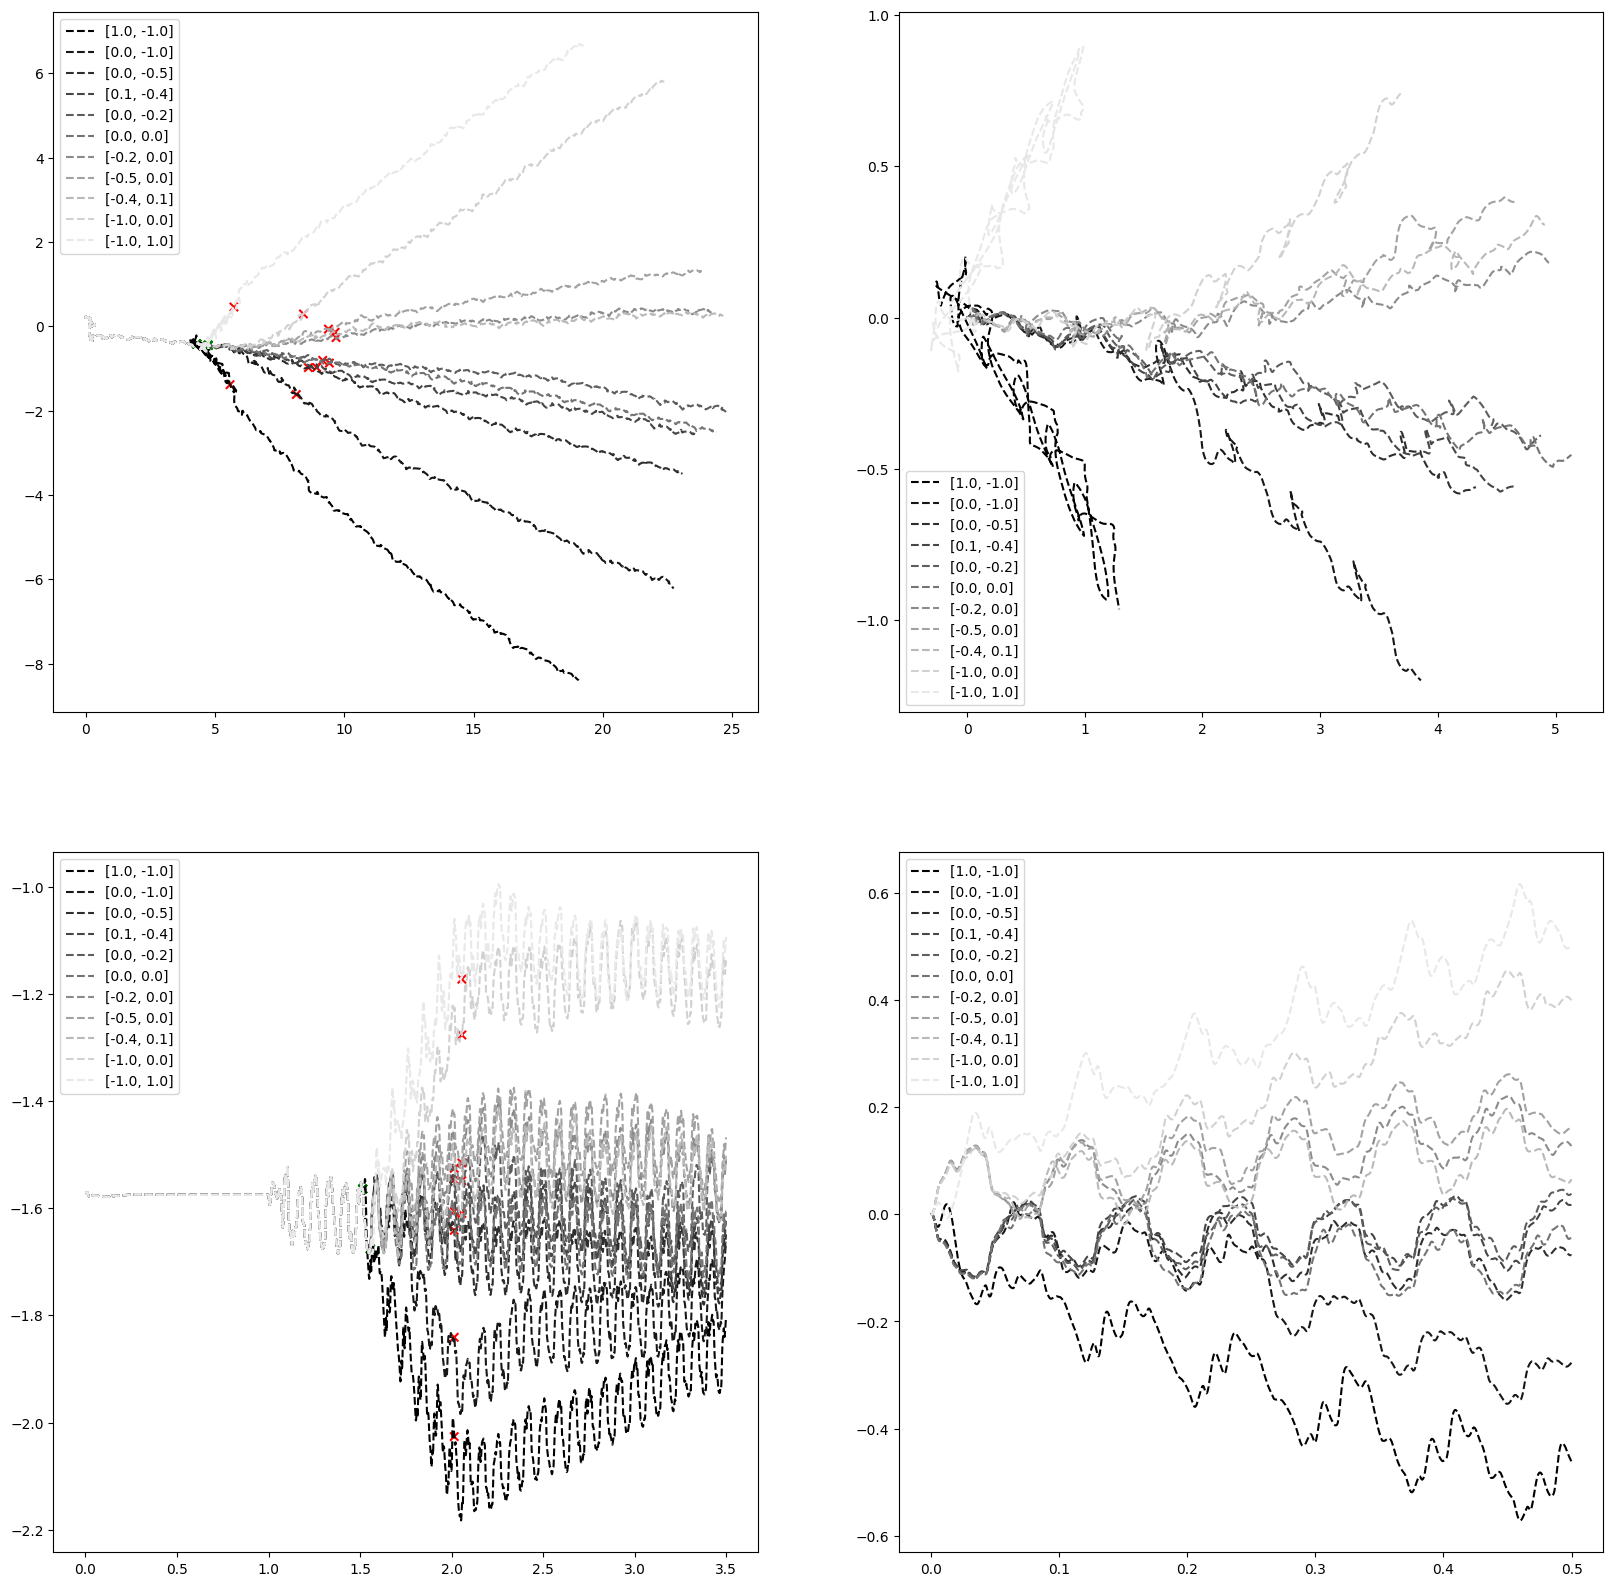

In [4]:
actions = [[0.0, 0.0], [0.0, -1.0], [-1.0, 0.0], [-0.5, 0.0], [0.0, -0.5], [0.1,-0.4], [-0.4, 0.1], [-1.0, 1.0], [1.0, -1.0], [0.0, -0.2], [-0.2, 0.0]]

# Rank actions from the highest first value to the lowest
if len(actions) > 1:
  actions = (np.array(actions)[np.argsort(np.diff(actions), axis=0)]).squeeze().tolist()
# Define gradient of colors
colors = (np.repeat(np.arange(len(actions)), 3).reshape((len(actions), 3))/len(actions)).tolist()

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()

time = np.arange(run_time/nmf.timestep+nmf.n_stabilisation_steps)*nmf.timestep

all_phases = []
all_amps = []
all_obs = []

for i, turn_action in enumerate(actions):
  
  obs_list, turn_start, turn_end, phases, amplitudes, stumble_active, retract_active, nmf = generate_turning(turn_action)
  video_path = Path(f"turning_validation/tripod_action{turn_action}_tmstp{nmf.timestep}_seed{seed}_runtime{run_time}.mp4")
  if nmf.sim_params.render_mode == "saved":
      nmf.save_video(video_path, 0)

  cart_pos = np.array([obs["fly"][0] for obs in obs_list])
  axs[0].plot(cart_pos[:, 0], cart_pos[:, 1], "--", label = turn_action, color=colors[i])
  axs[0].scatter(cart_pos[[turn_start, int(turn_end)], 0],
                  cart_pos[[turn_start, int(turn_end)], 1],
                    marker="x", c=["green" , "red"])
  axs[1].plot(cart_pos[turn_start:int(turn_end), 0] - cart_pos[turn_start, 0],
              cart_pos[turn_start:int(turn_end), 1] - cart_pos[turn_start, 1],
                "--", label = turn_action, color=colors[i])
  orient = np.array([obs["fly"][2] for obs in obs_list])
  axs[2].plot(time, orient[:, 0], "--", label = turn_action, color=colors[i])
  axs[2].scatter(time[[turn_start, int(turn_end)]],
                  orient[[turn_start, int(turn_end)], 0],
                    marker="x", c=["green" , "red"])
  axs[3].plot(time[turn_start:int(turn_end)] - time[turn_start],
              orient[turn_start:int(turn_end), 0] - orient[turn_start, 0],    
              "--", label = turn_action, color=colors[i])
  all_phases.append(phases)
  all_amps.append(amplitudes)
  all_obs.append(obs_list)

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.savefig(f"turning_validation/turning_validation_seed{seed}_tmstp{nmf.timestep}_runtime{run_time}.png")

In [5]:
from ipywidgets import Video
Video.from_file(Path(f"turning_validation/tripod_action{actions[0]}_tmstp{nmf.timestep}_seed{seed}_runtime{run_time}.mp4"))

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

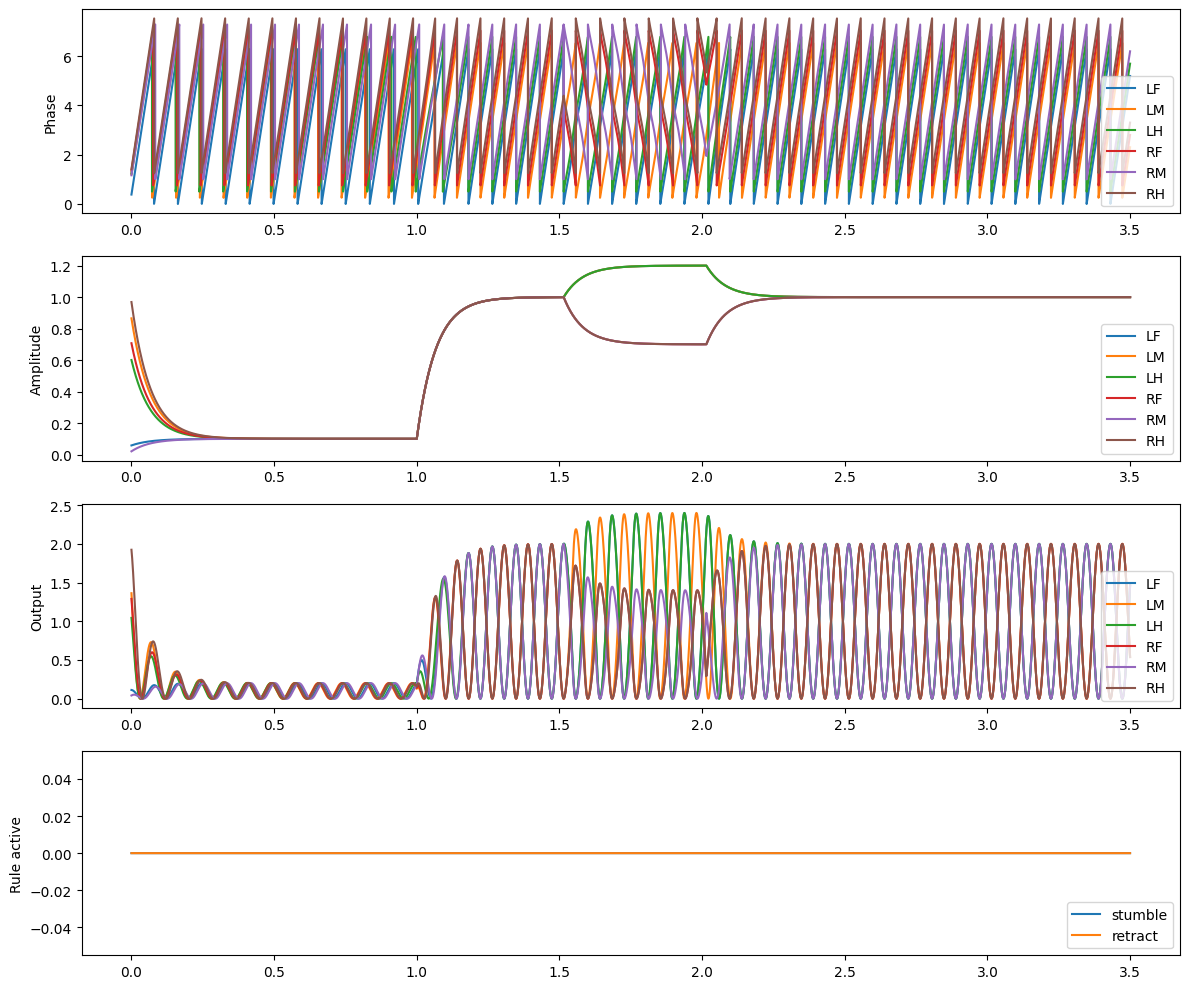

In [6]:
i=0
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
plot_phase_amp_output_rules(
    all_phases[i] + np.arange(len(legs))*0.25,
    all_amps[i],
    sine_output(all_phases[i], all_amps[i]),
    [stumble_active, retract_active],
    labels=legs,
    rule_labels=["stumble","retract"],
    timestep=nmf.timestep
)
plt.show()

In [7]:
inv_phases = np.array(all_phases[0])
inv_phases[nmf.n_stabilisation_steps:] += np.pi
amps = all_amps[0]

nmf_base = NeuroMechFlyMuJoCo(sim_params=sim_params,
                              init_pose=nmf.init_pose,
                              actuated_joints=nmf.actuated_joints,
                              spawn_pos = nmf.spawn_pos,
                              )

obs_list = []

flip_indices = [3, 4, 5, 0, 1, 2]

match_leg_to_joints_invert = np.array(
            [
                flip_indices[i]
                for joint in nmf.actuated_joints
                for i, leg in enumerate(legs)
                if leg in joint
            ]
        )

used_match_leg_to_joints = match_leg_to_joints_invert # nmf.match_leg_to_joints


for i in range(len(amps)):
    
    period = 2 * np.pi
    t_indices = np.round(
        np.mod(
            phases[i] * nmf.interp_step_duration / period,
            nmf.interp_step_duration - 1,
        )
    ).astype(int)
    indices = t_indices[used_match_leg_to_joints]
    joints_action = nmf.step_data[nmf.joint_ids, 0]
    
    if i > nmf.n_stabilisation_steps:
        
        joints_action += (
            nmf.step_data[nmf.joint_ids, indices] - nmf.step_data[nmf.joint_ids, 0]
        ) * amps[i][used_match_leg_to_joints]
        indices_in_order = indices[nmf.joints_to_leg]
        leg_in_stance = np.logical_or(indices_in_order < nmf.swing_starts_in_order,
                                            indices_in_order > nmf.stance_starts_in_order)
        adhesion_signal = leg_in_stance
    else:
        adhesion_signal = np.zeros(6, dtype=bool)
        #joints_action = nmf.step_data[nmf.joint_ids, nmf.interp_step_duration//2]

    
    obs, reward, terminated, truncated, info = nmf_base.step({"joints": joints_action, "adhesion": adhesion_signal})
    nmf_base.render()

    obs_list.append(obs)

video_path = Path(f"turning_validation/tripod_action{actions[0]}_inv_input_joint_angles_tmstp{nmf.timestep}.mp4")
nmf_base.save_video(video_path, 0)
all_obs.append(obs_list)

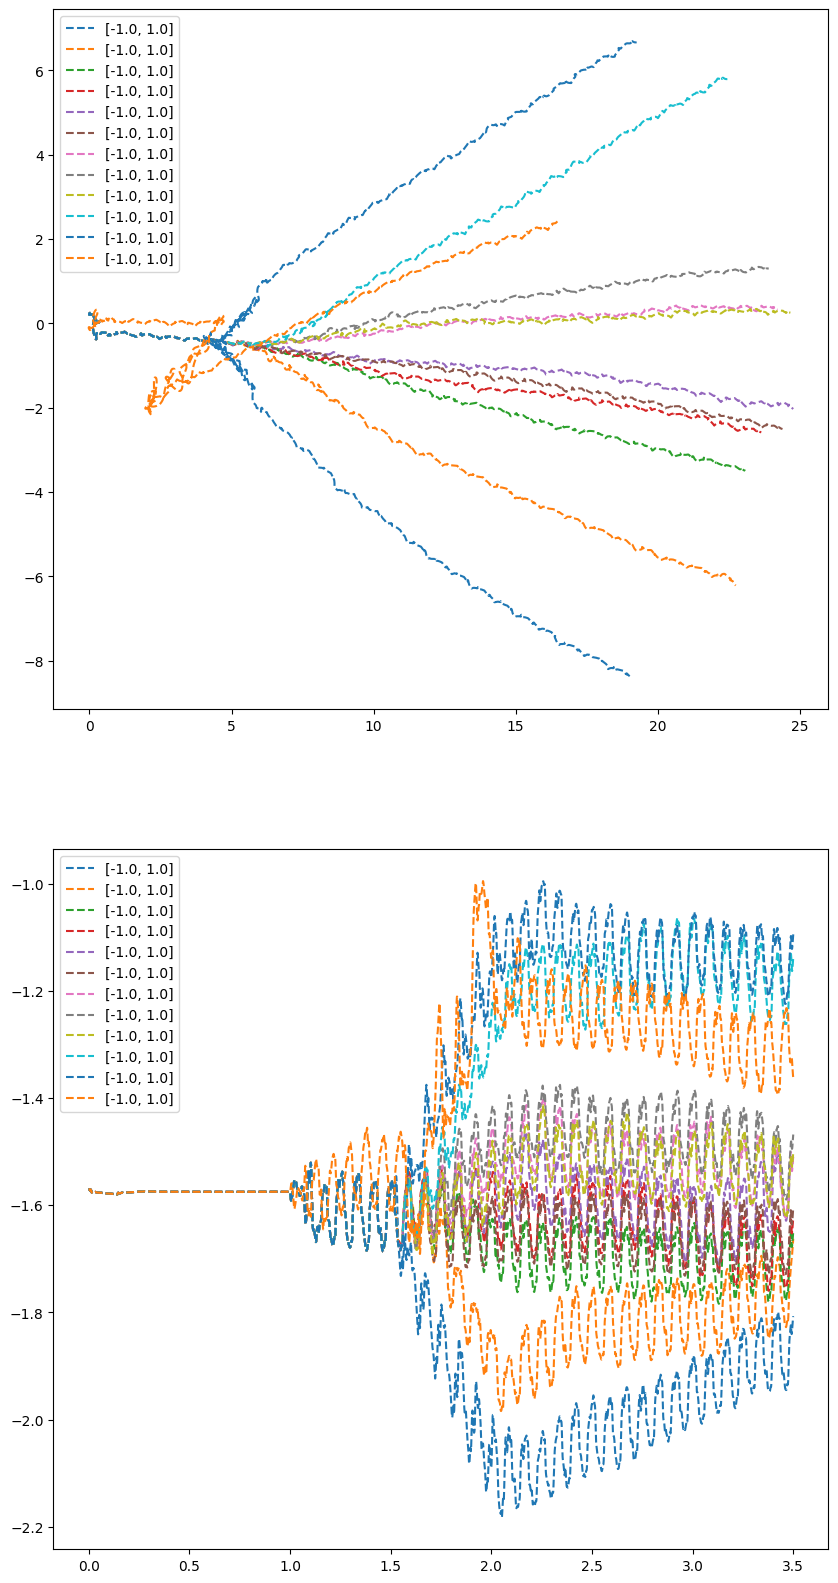

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 20))
axs = axs.flatten()

time = np.arange(run_time/nmf.timestep+nmf.n_stabilisation_steps)*nmf.timestep

for obs_list in all_obs:
    cart_pos = np.array([obs["fly"][0] for obs in obs_list])
    axs[0].plot(cart_pos[:, 0], cart_pos[:, 1], "--", label = turn_action)
    
    orient = np.array([obs["fly"][2] for obs in obs_list])
    axs[1].plot(time, orient[:, 0], "--", label = turn_action)
axs[0].legend()
axs[1].legend()
    

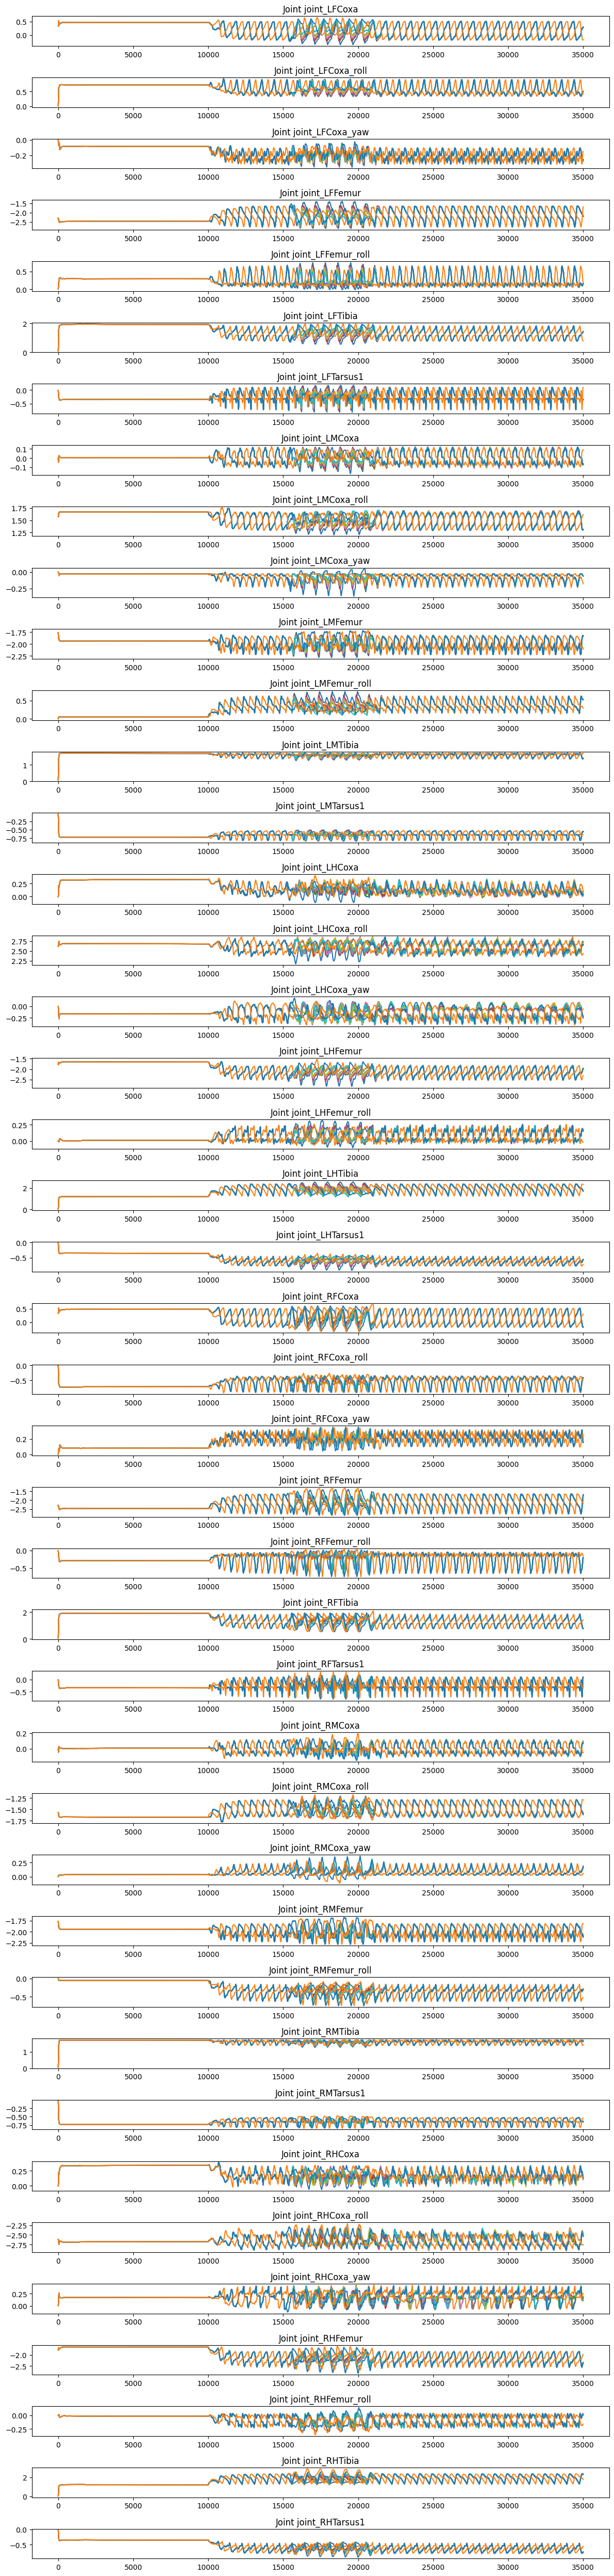

In [9]:
fig, axs = plt.subplots(len(nmf.actuated_joints), 1, figsize=(12, 50))

for j, obs_list in enumerate(all_obs):    
    joint_data = np.array([obs["joints"][0] for obs in obs_list])
    for i, joint in enumerate(nmf.actuated_joints):
        axs[i].plot(joint_data[:, i])
        axs[i].set_title("Joint {}".format(joint))
plt.tight_layout()

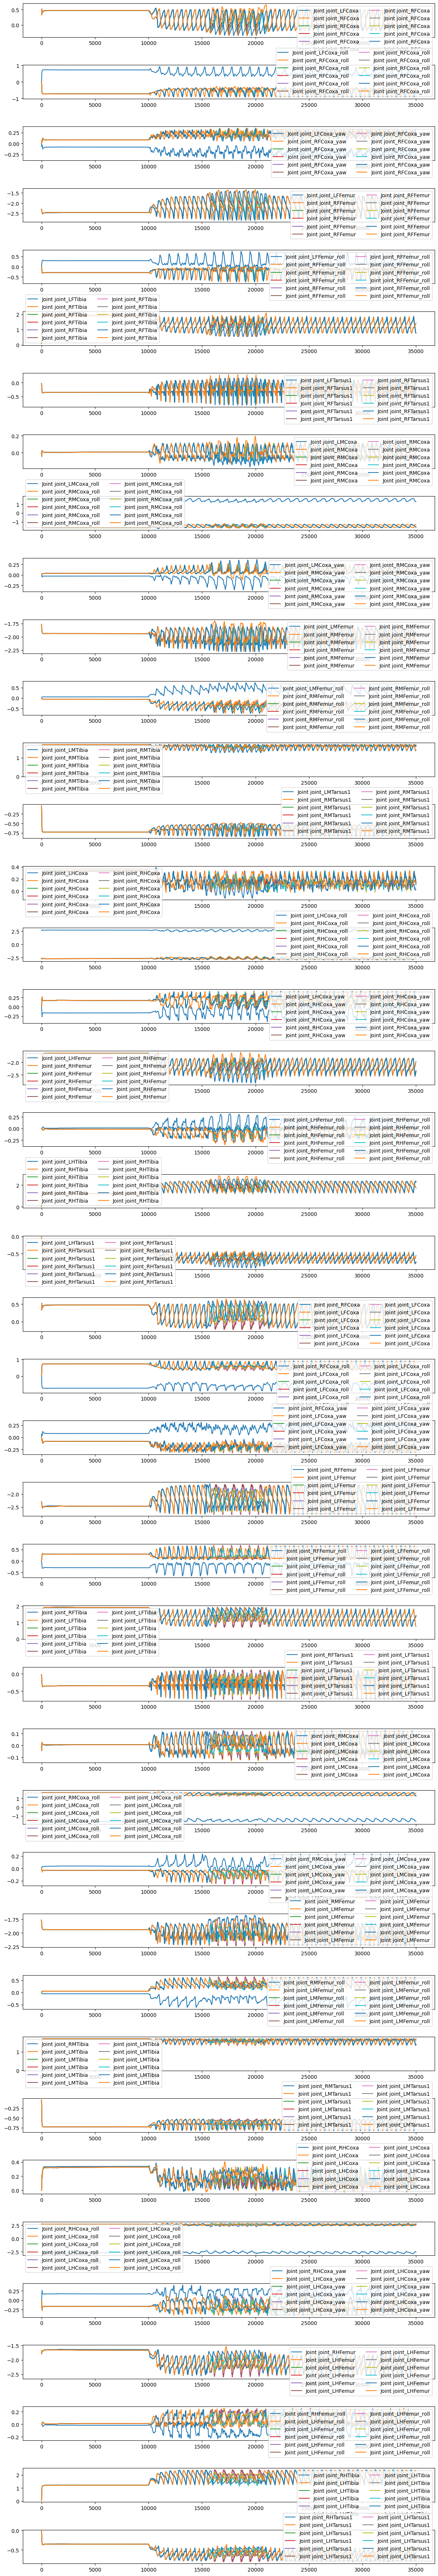

In [10]:
fig, axs = plt.subplots(len(nmf.actuated_joints), 1, figsize=(12, 70))
n_joint = len(nmf.actuated_joints)

for j, obs_list in enumerate(all_obs):    
    joint_data = np.array([obs["joints"][0] for obs in obs_list])
    for i, joint in enumerate(nmf.actuated_joints):
        if j == 0:
            axs[i].plot(joint_data[:, i], label="Joint {}".format(joint))
        else:
            mirror_id = (i + n_joint//2) % n_joint
            axs[i].plot(joint_data[:, mirror_id], label="Joint {}".format(nmf.actuated_joints[mirror_id]))
            axs[i].legend(ncols=2)
plt.tight_layout()